# Including Single Particle and First Band Approximation Functions

In [1]:
using NBInclude
@nbinclude("Kagome SP.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))

get_num_mb_op

# Initial Parameters

In [2]:
# Lattice sizes
Nx = 3; Ny = 3; N=Nx*Ny*3; cut_off = 9;
# Total particle number array
PN = [0,1,2];
# Lattice potential
U = 2;
# Model hopping parameters
t1 = -1; L1 = 0.28; t2 = 0.3; L2 = 0.2;
# t1=-1;L1=0 ;t2=L2=0 # t1=L1=0;t2=L2=-1 # t1=t2=-1;L1=L2=0

# Single Particle

In [3]:
sp_basis = NLevelBasis(N)
sp_matrix = get_SP_H(Nx, Ny, t1, L1, t2, L2);

In [4]:
H1 = get_sp_op_data(sp_basis, N, sp_matrix);

In [5]:
#check operator form
eigenenergies(dense(H1)) == eigenenergies(dense(sp_matrix)) #true
eigenenergies(dense(sp_matrix))

27-element Vector{Float64}:
 -2.800000000000002
 -2.777794549146835
 -2.777794549146835
 -2.7577743801435055
 -2.757774380143503
 -2.7577743801435024
 -2.7577743801435024
 -2.757774380143501
 -2.7577743801434993
 -0.4222054508531637
 -0.4222054508531625
  0.30352197249769414
  0.3035219724976957
  ⋮
  0.30352197249769675
  0.3035219724976984
  1.1228718707889798
  1.6771281292110205
  2.4542524076458045
  2.4542524076458045
  2.4542524076458054
  2.4542524076458054
  2.4542524076458063
  2.4542524076458077
  3.1999999999999997
  3.200000000000002

In [6]:
sub_states = get_sub_states(H1, cut_off);

In [7]:
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [8]:
H1_sub = get_subspace_op(H1, P, Pt);

In [9]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

# Many Body

In [10]:
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);

In [11]:
H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub);

In [12]:
@nbinclude("Kagome MB .ipynb"; regex=r"#.*executeme");

In [13]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN)
# Interaction part
H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off);

# Constructing Total Hamiltonian

In [14]:
# Kinetic part
H1cut = SparseOperator(basis_cut_mb)
H1cut.data = H1_MB.data

number_mb_list_operators = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)

# Impurity potential
V = 4;V_imp_site=10
V_imp = V * number_mb_list_operators[V_imp_site];

# Total hamiltonian
H_total = H1cut + H_Int + V_imp;

# Exact Diagonalization

In [15]:
using DataFrames

E, UU = eigenstates(dense((H_total+dagger(H_total))/2))

# Filter of particle number
function get_energies(pn, E, UU, basis)
    
    PN_Energies = Array{Float64}(undef, length(E), 2)
    
    for i in 1:length(E)
        PN_Energies[i] = round(expect(number(basis), UU[i])) 
        PN_Energies[i,2] = E[i] 
    end
    
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [16]:
PN

3-element Vector{Int64}:
 0
 1
 2

In [17]:
pn = 2.0
df = get_energies(pn, E, UU, basis_cut_mb)
filtered_energies = Matrix(df)[:,2]
show(stdout,"text/plain", filtered_energies) 

45-element Vector{Float64}:
 -5.5794047993858875
 -5.553681182704222
 -5.5502918978613085
 -5.546081019986926
 -5.545890637526001
 -5.544135514346655
 -5.542194193929212
 -5.537619225280678
 -5.537243825460339
 -5.534198985750688
 -5.530634911813002
 -5.525891244647593
 -5.525708507402733
 -5.5229628856109185
 -5.522019785699928
 -5.5215427071901555
 -5.520763528297233
 -5.517754265631777
 -5.517524037174848
 -5.514022462779471
 -5.38651651683684
 -5.342608636750668
 -5.295142678217575
 -5.291450551925511
 -5.290234136590389
 -5.288421220596007
 -5.288380585117754
 -5.27039140983461
 -5.245695594506123
 -5.1760123774935645
 -5.144085925555531
 -5.1393797944160085
 -5.131881362742777
 -5.112815015771483
 -5.111255252291818
 -5.067366576703457
 -4.204459093468996
 -4.183054278067694
 -4.181063066020167
 -4.161279916494568
 -4.14431837672703
 -4.104980991788661
 -4.0368927697720185
 -3.8954449106057125
 -2.506323801439016

Allta ki fonksiyonun çalışması için, dizide ki filtre edilmiş parçacık sayısı her zaman en büyük değer de olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [18]:
# Eigenstates of filtered particles
function Restricted_Hubbard_States(states)
    number_of_states = length(filtered_energies)
    return states[1:number_of_states];
end

Restricted_Hubbard_States (generic function with 1 method)

In [19]:
r_hubbard_states = Restricted_Hubbard_States(UU);

# Density-Profile

In [20]:
# METHOD 1

NM_MB_Array_Storage = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb),N);
NM_MB_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb));
for m in 1:N
    for i in 1:length(basis_cut_mb)
        for j in 1:length(basis_cut_mb)
            #NM_MB_Matrix[i,j] = num_mb_list[m].data[i,j]
            NM_MB_Matrix[i,j] = number_mb_list_operators[m].data[i,j]
            # NOT: num_mb_list ile number_mb_list_operators bazları farklı ama içerikleri aynı!
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
end

BL = BR = basis_cut_mb
index_number_op = 1
T = NM_MB_Array_Storage[:,:,index_number_op]
Op = Operator(BL,BR,T)
index_eigen_states = 1
println(expect(Op, r_hubbard_states[index_eigen_states]))

# METHOD 2
# println(expect(number_mb_list_operators[index_number_op],r_hubbard_states[index_eigen_states]))

0.07241418694188319 - 6.80336863234654e-18im


In [21]:
Sum = 0
total_expect_list=[]

# Iteration over number operator index
for i in 1:N
    T = NM_MB_Array_Storage[:,:,i]
    Op = Operator(BL,BR,T)
    n_i = 0
    # Iteration over eigenstates index
    for index_eig_states in 1:length(filtered_energies)       
        Sum += expect(Op, r_hubbard_states[index_eig_states])
        #println(expect(Op, r_hubbard_states[index_eig_states]))
        
        # !
        # Bunun homojen olmasını mı gerekiyordu? NEDEN?
        # !
        
        n_i += expect(Op, r_hubbard_states[index_eig_states])
    end
    push!(total_expect_list,n_i)
end

In [22]:
index_eig_states = 1
Sum = 0
expect_list=[]

for i in 1:N
    T = NM_MB_Array_Storage[:,:,i]
    Op = Operator(BL,BR,T)      
    Sum += expect(Op, r_hubbard_states[index_eig_states])
    #println(i,"\t",expect(Op, r_hubbard_states[index_eig_states]))
    push!(expect_list,expect(Op, r_hubbard_states[index_eig_states]))
end
Sum

2.000000000000001 - 4.753210086812232e-17im

In [23]:
# Find x and y coordinates from given site index

function exp_list0(site_indx)
    
    x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:Nx*Ny*3)
    y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:Nx*Ny*3)
    
    x = hcat(x_co, y_co)[site_indx, 1]
    y = hcat(x_co, y_co)[site_indx, 2] 
    
    #!!! 
    # Burada beklenen değerlerin sıralamasının site bazında olduğunu varsaydım!!!!
    # HOFSTADTER'DA BU AÇIK AMA KAGOME'DE EMİN DEĞİLİM??
    #!!!
    exp_val = real(expect_list)[site_indx] 
    
    return x, y, exp_val
end
exp_list0(5)

(2.0, 1.7320508075688772, 0.09248959600314034)

In [24]:
# Find site_index from given x and y coordinates

function exp_list1(Xx, Yy)
    co_list = hcat(x_co, y_co)
    site_indx = intersect(findall(x->x==Xx, co_list[:,1]), findall(x->x==Yy, co_list[:,2]))
    return real(expect_list)[site_indx] 
end

x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:Nx*Ny*3)
y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:Nx*Ny*3)
site_index = 2
Xx = x_co[site_index]
Yy = y_co[site_index]
print(site_index," => ",Xx,"\t",Yy," => ",exp_list1(Xx, Yy))

2 => 1.0	0.0 => [0.020561358375944156]

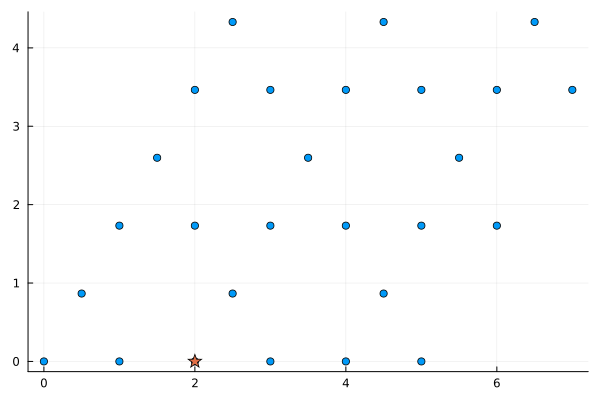

In [35]:
scatter(x_co,y_co,legend=false)
x_imp = exp_list0(V_imp_site)[1];y_imp=exp_list0(V_imp_site)[2]
scatter!([Int(x_imp)], [Int(y_imp)],markershape=:star5,markersize=7)

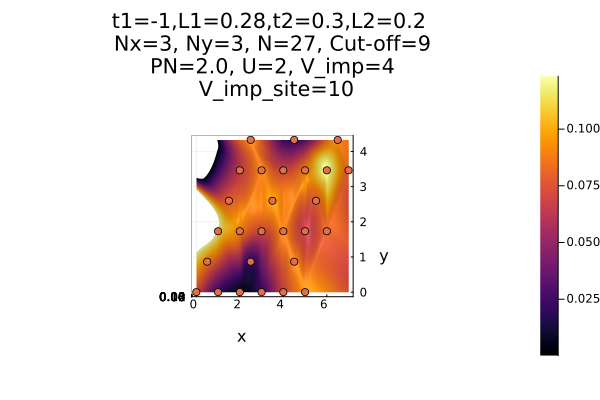

In [36]:
# Plotting density

# x = Float64[]
# for i in x_co
#     push!(x,i)
# end
# y = Float64[]
# for i in y_co
#     push!(y,i)
# end

z = exp_list1.(x_co, y_co)
z = collect(Iterators.flatten(z))
surface(x_co,y_co,z,xlabel="x",ylabel="y", camera=(0,90))
title!("t1=$(t1),L1=$(L1),t2=$(t2),L2=$(L2) \n Nx=$(Nx), Ny=$(Ny), N=$(N), Cut-off=$(cut_off) \n PN=$(pn), U=$(U), V_imp=$(V) \n V_imp_site=$(V_imp_site)")

# Plot kagome as project to the plot of density profile
scatter!(x_co,y_co,0 .* z,camera=(0,90), legend=false)

# x_imp = exp_list0(V_imp_site)[1];y_imp=exp_list0(V_imp_site)[2]
# scatter!([Int(x_imp)], [Int(y_imp)], markershape=:star5, markersize=5, camera=(0,90), legend=false)
# savefig("V_imp_site=10.png") # Plot and then save it!

# Comparansion

In [27]:
#U çok küçükken (Band-Gap büyüdüğünde) subspace enerjileri, real-space enerjilerine yakınsar:

# MB_Hamiltonian = Kagome_Finite_U(Nx,Ny,Basis_MB,U,sp_op)
# real_space_finite_u = eigenenergies(dense(MB_Hamiltonian)); sub_space_finite_u = E_States[1]
# plot(1:length(real_space_finite_u[1:21]),real_space_finite_u,seriestype=:scatter,markershape=:star5,markersize=7,label="Real-Space")
# plot!(1:length(sub_space_finite_u),sub_space_finite_u,seriestype=:scatter,label="Sub-Space",legend=:topleft)
# title!("U=$(U)");xlabel!("n");ylabel!("E")